In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import timeit

### Testing convolution: simple example

In [2]:
img = np.array([
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
])

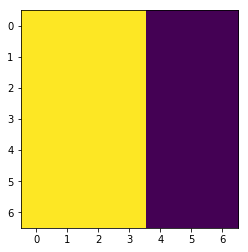

In [3]:
plt.imshow(img)

In [4]:
W = np.array([
    [1, 0, -1], 
    [1, 0, -1], 
    [1, 0, -1]
])

In [5]:
n = img.shape[0]
f = W.shape[0]
p = 0
s = 1
a = int((n+2*p-f)/s)+1

In [6]:
y = np.zeros((a,a))

In [7]:
for i in range(a):
    for j in range(a):
        y[i, j] = np.sum((img[i:i+f,j:j+f]*W))

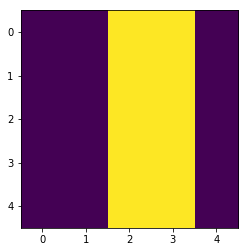

In [8]:
plt.imshow(y)

### Testing convolution: extending to multiple channels and training examples 

Defining an input

In [9]:
m = 12
nh_0 = 64
nw_0 = 64
nc_0 = 3

In [10]:
A_0 = np.random.rand(m, nh_0, nw_0, nc_0)
#A_0 = np.expand_dims(A_0,axis=len(A_0.shape))

Defining layer parameters

In [11]:
from meik.utils.activations import relu, drelu

In [12]:
f_1 = 5
nc_1 = 10
s_1 = 1
p_1 = 0
g_1 = relu
dg_1 = drelu

In [13]:
nh_1 = int((nh_0+2*p_1-f_1)/s_1)+1
nw_1 = int((nw_0+2*p_1-f_1)/s_1)+1

Defining layer variables

In [14]:
W_1 = np.random.rand(f_1, f_1, nc_0, nc_1)

In [15]:
b_1 = np.random.rand(1, 1, 1, nc_1)

Computing forwardprop

In [16]:
def forwardprop_v1(A_0, params):
    
    W, b, g, f, s, nh, nw, nc = params
    
    Z = np.zeros((m,nh,nw,nc))
    
    for i in range(nh):
        
        for j in range(nw):
            
            axes = tuple(i for i in range(1,len(Z.shape)))
            
            # Note on np.newaxis: extension of A dimension such that it is copied along the additional axis for multiplication
            Z[:, i, j, :] = np.sum((A_0[:,i*s:i*s+f,j*s:j*s+f,:,np.newaxis]*W), axis=axes)
            
    Z += b
    
    A = g(Z)

    return A

In [17]:
A_1 = forwardprop_v1(A_0, [W_1, b_1, g_1, f_1, s_1, nh_1, nw_1, nc_1])

In [18]:
timeit('forwardprop_v1(A_0, [W_1, b_1, g_1, f_1, s_1, nh_1, nw_1, nc_1])', globals=globals(), number=100)/100

0.19218656534038017

### Computing backprop v1

In [19]:
dA_1 = np.random.random(A_1.shape)

In [20]:
dZ_1 = dg_1(A_1)*dA_1

In [21]:
axes = tuple(i for i in range(0,len(dA_1.shape)-1))
db_1 = 1./m * np.sum(dZ_1, axis=axes, keepdims=True)

In [22]:
#For 2D input, single example, single filter

A = A_0[0,:,:,0]
W = W_1[:,:,0,0]
dZ = dZ_1[0,:,:,0]
dW = np.zeros(W.shape)
dA = np.zeros(A.shape)

for i in range(nh_1):
    
    for j in range(nw_1):

            dW += A[i:i+f_1,j:j+f_1]*dZ[i,j]
            
            dA[i:i+f_1,j:j+f_1] += dZ[i,j]*W

In [23]:
#For 3D input, single example, single filter

A = A_0[0,:,:,:]
W = W_1[:,:,:,0]
dZ = dZ_1[0,:,:,0]
dW = np.zeros(W.shape)
dA = np.zeros(A.shape)

for i in range(nh_1):
    
    for j in range(nw_1):
    
            dW += A[i:i+f_1,j:j+f_1,:]*dZ[i,j]
            
            dA[i:i+f_1,j:j+f_1,:] += dZ[i,j]*W

In [24]:
#For 3D input, single example, multiple filters

A = A_0[0,:,:,:] 
W = W_1[:,:,:,:]
dZ = dZ_1[0,:,:,:]
dW = np.zeros(W.shape)
dA = np.zeros(A.shape)

for i in range(nh_1):
    
    for j in range(nw_1):
    
            dW += A[i:i+f_1,j:j+f_1,:,np.newaxis]*dZ[i,j,:]
            
            dA[i:i+f_1,j:j+f_1,:] += np.sum(W*dZ[i,j,:], axis=3, keepdims=False) #summing across layer 1 filters

In [25]:
#For 3D input, multiple examples, multiple filter

A = A_0[:,:,:,:] 
W = W_1[:,:,:,:]
dZ = dZ_1[:,:,:,:]
dW = np.zeros(W.shape)
dA = np.zeros(A.shape)

for i in range(nh_1):
    
    for j in range(nw_1):
        
            A_ = A[:,i:i+f_1,j:j+f_1,:,np.newaxis]
            dZ_ = dZ[:,i,j,:][:,np.newaxis,np.newaxis,np.newaxis,:] 
            
            dW += np.sum(A_*dZ_, axis=0, keepdims=False)
            
            W_ = W[np.newaxis]
            
            dA[:,i:i+f_1,j:j+f_1,:] += np.sum(W_*dZ_, axis=4, keepdims=False)
            
dW *= 1./m

In [26]:
def backprop(dA0, params):
    
    A, A0, W, dg = params
    
    m, nh_0, nw_0, nc_0 = A0.shape
    f, _, _, nc = W.shape
    
    dZ = dg(A)*dA0
    
    axes = tuple(i for i in range(0,len(dZ.shape)-1))
    db = 1./m * np.sum(dZ, axis=axes, keepdims=True)
    
    dW = np.zeros(W.shape)
    dA = np.zeros(A0.shape)
    
    for i in range(nh):

        for j in range(nw):

                A0_ = A0[:,i:i+f,j:j+f,:,np.newaxis]
                dZ_ = dZ[:,i,j,:][:,np.newaxis,np.newaxis,np.newaxis,:] 

                dW += np.sum(A0_*dZ_, axis=0, keepdims=False)

                W_ = W[np.newaxis]

                dA[:,i:i+f,j:j+f,:] += np.sum(W_*dZ_, axis=4, keepdims=False)

    dW *= 1./m
    
    return dA, dW

### Convolution as matrix multiplication

An easier to understand implementation using matrix multiplication: http://cs231n.github.io/convolutional-networks/

In [27]:
def im2col(A, f, s):
    
    m, nh_0, nw_0, nc_0 = A.shape
    
    nh = int((nh_0-f)/s)+1
    nw = int((nw_0-f)/s)+1
    
    out = np.zeros((m, f*f*nc_0, nh*nw))
    
    for i in range(nh):

        for j in range(nw):

               out[:, :, i*nw+j] = A[:,i*s:i*s+f,j*s:j*s+f,:].reshape(m, f*f*nc_0)
                
    return out

In [28]:
def forwardprop(A0, params):
    
    W, b, g, f, s, nh, nw, nc = params
    
    A0_col = im2col(A0, f, s)
    
    m, _, _, nc_0 = A0.shape
    
    W = W.reshape(f*f*nc_0,nc).T
    
    Z = np.zeros((m, nh, nw, nc))
    
    for i in range(m):
        
        Z[i] = np.dot(W,A0_col[i]).T.reshape(1, nh, nw, nc)
        
    Z += b
    
    A = g(Z)
    
    return A
    

In [29]:
A0_col = im2col(A_0, f_1, s_1)

In [30]:
A = forwardprop(A_0, [W_1, b_1, g_1, f_1, s_1, nh_1, nw_1, nc_1])

Checking if it produces the same result as previous implementation:

In [31]:
np.all(A_1 == A)

True

Testing the speed:

In [32]:
timeit('forwardprop(A_0, [W_1, b_1, g_1, f_1, s_1, nh_1, nw_1, nc_1])', globals=globals(), number=100)/100

0.04996047879976686

Goes to show that it is also a lot more efficient implementation. 

A point to note is that im2col seems to take the majority of the computation. Can this be done more efficiently?

In [33]:
timeit('im2col(A_0, f_1, s_1)', globals=globals(), number=100)/100

0.043593181460164485

### An attempt to improve im2col speed: 2D case

Idea from: https://stackoverflow.com/questions/30109068/implement-matlabs-im2col-sliding-in-python/30110497

Generating a 2D test case

In [34]:
V = np.arange(15)[:,None]*5+np.arange(5)
f = 3
s = 1

In [35]:
def im2col_2d(A, f, s):
    
    nh_0, nw_0 = A.shape
    
    nh = int((nh_0-f)/s)+1
    nw = int((nw_0-f)/s)+1
    
    out = []
    
    for i in range(nh):

        for j in range(nw):

               out.append(A[i*s:i*s+f,j*s:j*s+f].flatten())
                
    return np.array(out).flatten()

In [36]:
def im2col_2d_idxs_bc(nh_0, nw_0, f, s):
      
    nh = int((nh_0-f)/s)+1
    nw = int((nw_0-f)/s)+1
    
    # generating indexes of filter window on flattened 2D image
    # for location (0,0) in the output image
    filter_idxs = np.arange(f)[:,np.newaxis]*nw_0 + np.arange(f)

    # generating the index in the flattened 2D image where the filter starts
    # for each location in the output image
    offset_idxs = (np.arange(nh)*s*nw_0)[:,np.newaxis] + np.arange(nw)*s
    
    # generating the full set of indices by generating a set of filter indices
    # for each start location 
    idxs = (offset_idxs.flatten()[:,np.newaxis]+filter_idxs.flatten()).flatten()
    
    return idxs

In [37]:
def im2col_2d_bc(A, f, s):
    
    nh_0, nw_0 = A.shape
    
    idxs = im2col_2d_idxs_bc(nh_0, nw_0, f, s)
    
    return A.flatten()[idxs]

Checking the two implementations produce the same result

In [38]:
np.all(im2col_2d_bc(V,f,s) == im2col_2d(V,f,s))

True

Timing the functions

In [39]:
timeit('im2col_2d(V, f, s)', globals=globals(), number=10000)/10000

8.100752740283497e-05

In [40]:
timeit('im2col_2d_idxs_bc(V.shape[0], V.shape[1], f, s)', globals=globals(), number=10000)/10000

2.5015962700126692e-05

In [41]:
timeit('im2col_2d_bc(V, f, s)', globals=globals(), number=10000)/10000

2.537676209467463e-05

Strategy of using broadcasting is 3x faster according to this simple test. It seems reasonable to extend to 3D. But its important to note that the generation of the indexes takes a significant portion of the time and this only needs to be done once per layer at initialization!

### An attempt to improve im2col speed: extending to 3D

Generating test case

In [42]:
m = 2
nh_0 = 4
nw_0 = 6
nc_0 = 3

In [43]:
A0 = np.arange(m*nh_0*nw_0*nc_0).reshape(m, nh_0, nw_0, nc_0)

In [44]:
# each channel contains a 2D feature image
A0[0,:,:,0]

array([[ 0,  3,  6,  9, 12, 15],
       [18, 21, 24, 27, 30, 33],
       [36, 39, 42, 45, 48, 51],
       [54, 57, 60, 63, 66, 69]])

In [45]:
f = 2
nc = 5
s = 1

In [46]:
nh = int((nh_0-f)/s)+1
nw = int((nw_0-f)/s)+1

In [47]:
def im2col_bc(A,f,s,idxs=None):
    
    m, nh_0, nw_0, nc_0 = A.shape
    
    nh = int((nh_0-f)/s)+1
    nw = int((nw_0-f)/s)+1
    
    if type(idxs)==type(None):
        idxs = im2col_2d_idxs_bc(nh_0, nw_0, f, s)
    
    # Note: arranging colums where channels are appended to each other pixel by pixel
    return np.swapaxes(A0.reshape(m,nh_0*nw_0,nc_0)[:,idxs,:].reshape(m,nh*nw,f*f*nc_0),1,2)

In [48]:
# arranging colums where each 2D image is flattened then appended channel by channel
# np.swapaxes(A0.reshape(m,nh_0*nw_0,nc_0)[0,idxs,:].reshape(nw*nh,f*f,nc_0),1,2).reshape(nw*nh,f*f*nc_0).T

Testing that the two methods produce the same result

In [49]:
A0_col = im2col(A0,f,s)

In [50]:
A0_col_bc = im2col_bc(A0,f,s)

In [51]:
np.all(A0_col == A0_col_bc)

True

Note: indexes can also be done explicitly in 3D

In [52]:
def im2col_3d_idxs_bc(nh_0, nw_0, nc_0, f, s):
    
    nh = int((nh_0-f)/s)+1
    nw = int((nw_0-f)/s)+1
    
    filter_idxs = ((np.arange(f)[:,None]*nw_0*nc_0 + np.arange(f)*nc_0)[:,:,None] + np.arange(nc_0)).flatten()
    
    offset_idxs = ((np.arange(nh)*s*nw_0*nc_0)[:,None] + np.arange(nw)*s*nc_0).flatten()
    
    idxs = offset_idxs[:,None] + filter_idxs
    
    return idxs

In [53]:
A0_col_3d_bc = np.swapaxes(A0.reshape(m,nh_0*nw_0*nc_0)[:,im2col_3d_idxs_bc(nh_0, nw_0, nc_0, f, s)].reshape(m,nh*nw,f*f*nc_0),1,2)

In [54]:
np.all(A0_col_3d_bc == A0_col_bc)

True

Testing speed of new implementation

In [55]:
timeit('im2col(A0, f, s)', globals=globals(), number=10000)/10000

3.990549599984661e-05

In [56]:
timeit('im2col_bc(A0, f, s)', globals=globals(), number=10000)/10000

3.309431130182929e-05

The speed improvement is not significant when indexes have to be generated. However, what about in the case that they have already been calculated?

In [57]:
idxs = im2col_2d_idxs_bc(nh_0, nw_0, f, s)

In [58]:
timeit('im2col_bc(A0, f, s, idxs=idxs)', globals=globals(), number=100000)/100000

9.81916354969144e-06

We experience a 4x speedup with the new method compared to the old!

### Convolution backprop as matrix multiplication

Setting up dummy task

In [59]:
from meik.utils.activations import relu, drelu

In [60]:
m = 2
nh_0 = 4
nw_0 = 6
nc_0 = 3

In [61]:
A0 = np.arange(m*nh_0*nw_0*nc_0).reshape(m, nh_0, nw_0, nc_0)

In [62]:
f = 2
nc = 5
s = 1

In [63]:
nh = int((nh_0-f)/s)+1
nw = int((nw_0-f)/s)+1

In [64]:
W = np.random.rand(f, f, nc_0, nc)
b = np.random.rand(1, 1, 1, nc)

In [65]:
g = relu
dg = drelu

In [66]:
A = forwardprop(A0, [W, b, g, f, s, nh, nw, nc])

In [67]:
dA0 = np.arange(m*nh*nw*nc).reshape(m, nh, nw, nc)

In [68]:
idxs = im2col_3d_idxs_bc(nh_0, nw_0, nc_0, f, s)

In [69]:
def backprop_col(dA0, params):
    
    A, A0, A0_col, W, dg, idxs = params
    
    m, nh_0, nw_0, nc_0 = A0.shape
    f, f, _, nc = W.shape
    
    nh = int((nh_0-f)/s)+1
    nw = int((nw_0-f)/s)+1
    
    dZ = dA0*dg(A)
            
    W_ = W.reshape(f*f*nc_0, nc)
    dZ_ = np.swapaxes(dZ.reshape(m, nh*nw, nc),1,2)
    
    dW_ = np.zeros(W_.shape)
    dA_col = np.zeros(A0_col.shape)
    
    axes = tuple(np.arange(len(dZ.shape)-1))
    db = 1./m * np.sum(dZ, axis=axes, keepdims=True)
    
    for i in range(m):
        
        dA_col[i] = np.dot(W_, dZ_[i])
        dW_ += np.dot(A0_col[i], dZ_[i].T)
    
    dW_ *= 1./m

    dA = np.zeros(A0.shape).flatten()
    
    # col2im_v1: doesn't seem efficient since we have to loop -> issue of no accumulation with fancy indexing
    #    for i in range(nw*nh):
    #        dA[:, idxs[i,:]] += dA_col[:,:,i]
 
    # col2im_v2: using np.ufunc.at
    # generating indices for flattening across training examples
    idxs_m = ((np.arange((m),dtype=np.int8)*nh_0*nw_0*nc_0)[:,None] + idxs.flatten()).flatten()
    
    # flattening where features (f x f x nc_0), then training examples, are concatenated
    dA_col = np.swapaxes(dA_col,1,2).flatten()
    
    # adds dA_col to the correct location in the input volume 
    # by accumulating the result for elements that are indexed multiple times
    np.add.at(dA, idxs_m, dA_col)
    
    dA = dA.reshape(A0.shape)
    
    return dA, dW

In [70]:
dA, dW = backprop_col(dA0, [A, A0, A0_col, W, dg, idxs])

In [71]:
dA1, dW1 = backprop(dA0, [A, A0, W, dg])

Checking the two backprop methods produce the same result

In [72]:
np.all((dA - dA1) < 1e-12)

True

Timing the two versions

In [75]:
timeit('backprop_col(dA0, [A, A0, A0_col, W, dg, idxs])', globals=globals(), number=10000)/10000

9.624658320099115e-05

In [76]:
timeit('backprop(dA0, [A, A0, W, dg])', globals=globals(), number=10000)/10000

0.0005053380984987597

### Convolution layer class

In [ ]:
from meik.layers import Layer
from meik.initializer import Initializer
from meik.utils import activations

class Convolution3D(Layer):
    
    def __init__(self, filters, kernel_size, strides = 1, padding = 'valid', inputs = None, units = None, activation = None, initialization = None, init_params = None):
        
        Layer.__init__(self)
        
        self.id = None

        self.inputs = inputs
        self.units = units
        self.activation = activation
        self.optimizer = None #this gets assigned by model in model.build()
        
        self.f = kernel_size
        self.nc = filters
        self.s = strides

        if padding == 'valid':
            self.p = 0
        elif padding == 'same':
            self.p = kernel_size/2

        # setting activation methods
        self.g = getattr(activations, activation)
        self.dg = getattr(activations, 'd'+activation)

        # setting initializer
        self.initializer = Initializer(activation = activation, initialization = initialization, init_params = init_params)

        # declaring important variables            
        self.W = None
        self.b = None
        self.A = None
        self.A0 = None

        self.dW = None
        self.db = None

        # setting prediction of layer as forwardprop
        self.predict = self.forwardprop
        self.grad_check_predict = self.forwardprop

    def init(self, _id, inputs):
        
        self.id = _id
        self.inputs = inputs

        f = self.f
        s = self.s
        p = self.p
        nc = self.nc
        
        nh_0, nw_0, nc_0 = inputs

        self.nh = int((nh_0+2*p-f)/s)+1
        self.nw = int((nw_0+2*p-f)/s)+1
    
        self.units = (self.nh, self.nw, self.nc)
        
        self.W = self.initializer.initialize((f,f,nc_0,nc))
        self.b = np.zeros((1, 1, 1, nc))

# http://cs231n.github.io/convolutional-networks/
# implement matrix multiplication version

    def forwardprop(self, A0):

        g = self.g
        W = self.W
        b = self.b

        nh = self.nh
        nw = self.nw
        nc = self.nc

        m = A0.shape[0]

        Z = np.zeros((m,nh,nw,nc))
        
        axes = tuple(i for i in range(1,len(Z.shape)))

        for i in range(nh_1):
            for j in range(nw_1):
                # Note on np.newaxis: extension of A dimension such that it is copied along the additional axis for multiplication
                Z[:, i, j, :] = np.sum((A0[:,i:i+f_1,j:j+f_1,:,np.newaxis]*W), axis=axes) + b
        A = g(Z)

        self.A = A
        self.A0 = A0

        return A

    def backprop(self, dA0):

        dg = self.dg
        W = self.W
        A0 = self.A0
        A = self.A
        
        nh = self.nh
        nw = self.nw

        m = A.shape[0]

        dW = np.zeros(W.shape)
        dA = np.zeros(A0.shape)

        dZ = dA0*self.dg(A)

        axes = tuple(i for i in range(1,len(dZ.shape)))
        db = np.sum(dZ, axis=axes, keepdims=True)

        for i in range(nh):
            
            for j in range(nw):
                
                    A0_ = A0[:,i:i+f_1,j:j+f_1,:,np.newaxis]
                    dZ_ = dZ[:,i,j,:][:,np.newaxis,np.newaxis,np.newaxis,:] 
                    dW += 1./m * np.sum(A0_*dZ_, axis=0, keepdims=False)
                    
                    W_ = W[np.newaxis]
                    
                    dA[:,i:i+f_1,j:j+f_1,:] += np.sum(W_*dZ_, axis=4, keepdims=False)

        self.dW = dW
        self.db = db

        return dA
    
    def update(self):

        W = self.W
        b = self.b
        dW = self.dW
        db = self.db

        W, b = self.optimizer.update(W, b, dW, db)

        self.W = W
        self.b = b

### Testing forwardprop

In [ ]:
m = 12
nh_0 = 64
nw_0 = 64
nc_0 = 3

In [ ]:
A_0 = np.random.rand(m, nh_0, nw_0, nc_0)

In [ ]:
f_1 = 5
nc_1 = 10
s_1 = 1
p_1 = 0

In [ ]:
L1 = Convolution3D(nc_1, f_1, activation = 'relu', inputs = (nh_0, nw_0, nc_0))

In [ ]:
L1.init(0, (nh_0, nw_0, nc_0))

In [ ]:
A1 = L1.forwardprop(A_0)

### Testing backprop

In [ ]:
dA = L1.backprop(dA_1)

### Gradient checking

In [ ]:
from meik.models import Sequential
from meik.utils import gradient_check

In [ ]:
model = Sequential()

In [ ]:
model.add(Convolution3D(nc_1, f_1, strides = s_1, padding = 'valid', activation = 'relu', inputs = (nh_0, nw_0, nc_0)))

In [ ]:
X = A_0

In [ ]:
A = model.forwardprop(X)

In [ ]:
theta, dtheta = gradient_check.get_params(model)

In [ ]:
dtheta = np.zeros(theta.shape)

dAdtheta_list = []
epsilon = 1e-7

for i in range(10):

    tplus = theta.copy()   
    tplus[i] += epsilon
    
    model = gradient_check.set_params(model,tplus)
    dAplus = model.layers[0].forwardprop(X)
    
    tminus = theta.copy()
    tminus[i] -= epsilon
    
    model = gradient_check.set_params(model,tminus)
    dAminus = model.layers[0].forwardprop(X)
    
    dAdtheta = (dAplus - dAminus)/(2*epsilon)
    dAdtheta_list.append(dAdtheta)

In [ ]:
dAdtheta_list[0].shape

In [ ]:
dLdA = np.ones(dAdtheta.shape)

In [ ]:
dA = L1.backprop(dLdA)

In [ ]:
L1.dW

### MNIST with fully connected

Obtaining dataset

In [ ]:
from keras.datasets import mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

One-hot encoding labels

In [ ]:
def one_hot_encode(y):
    
    shape = tuple(list(y.shape)+[np.max(y)+1])
    l = np.zeros(shape)
    
    l[np.arange(l.shape[0]),y] = 1
    
    return l

In [ ]:
Y_train = one_hot_encode(y_train).T

In [ ]:
Y_test = one_hot_encode(y_test).T

Flattening inputs

In [ ]:
m, h, w = x_train.shape

In [ ]:
X_train = x_train.reshape(m, h*w).T

In [ ]:
n, h, w = x_test.shape

In [ ]:
X_test = x_test.reshape(n, h*w).T

Creating model

In [ ]:
from meik.models import Sequential
from meik.layers import Layer, Dense, Dropout, Batch_norm

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(units=64, activation='relu', inputs=28*28))
model.add(Batch_norm())
model.add(Dense(units=32, activation='relu'))
model.add(Batch_norm())
model.add(Dense(units=16, activation='relu'))
model.add(Batch_norm())
model.add(Dense(units=10, activation='softmax'))

In [ ]:
from meik import optimizers
optimizer = optimizers.Adam()

In [ ]:
metrics = ['accuracy', 'binary_crossentropy', 'confusion_matrix']

In [ ]:
model.build(loss='categorical_crossentropy', optimizer=optimizer, eval_metrics=metrics)

In [ ]:
X_train.shape

In [ ]:
model.train(X_train, Y_train, batch_size=64, epochs=1, verbose=1)

In [ ]:
from meik.utils.misc import plot_training_loss

In [ ]:
plot_training_loss(model, loss=model.params['loss'], mode='batch')

In [ ]:
score = model.evaluate(X_test,Y_test)